## Behavioral Cloning

In [101]:
import csv
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sklearn


lines = []

with open('./data/data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

print('loaded file')

image_paths = []
angles = []

for line in lines[1:]:
 
    center_current_path = './data/data/IMG/' + line[0].split('/')[-1]
    left_current_path = './data/data/IMG/' + line[1].split('/')[-1]
    right_current_path = './data/data/IMG/' + line[2].split('/')[-1]
    
    if float(line[3]) != 0:
        image_paths.extend((center_current_path, left_current_path, right_current_path))  
        angles.extend((float(line[3]), float(line[3]) + 0.2, float(line[3]) - 0.2))
    else:
        image_paths.append(center_current_path)  
        angles.append(float(line[3]))
               
print("Number of samples =", len(angles))

loaded file
Number of samples = 15386


In [102]:
print(keras.__version__)

2.1.5


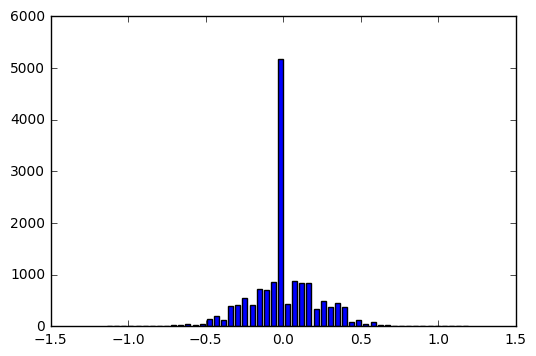

In [104]:
hist, bins = np.histogram(angles, bins=51)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist,align='center', width=width)
plt.show()

In [105]:
image_paths = np.asarray(image_paths)
angles = np.asarray(angles)

In [106]:
#randomly removing images with zero angles from the dataset
zero_inds = np.where(angles == 0)[0]
shuffle(zero_inds)

remove_inds = zero_inds[:int(0.4*len(zero_inds))]
image_paths = np.delete(image_paths, remove_inds)
angles = np.delete(angles, remove_inds)

print(len(zero_inds))
print(len(remove_inds))

print(len(image_paths))
print(len(angles))

4361
1744
13642
13642


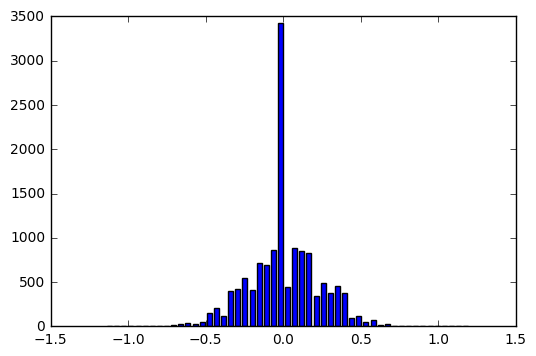

In [107]:
hist, bins = np.histogram(angles, bins=51)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist,align='center', width=width)
plt.show()

In [108]:
# Data Augmentation

# 1. add left and right camera images with some correction factor
# 2. add flip images with negative steering angle
# 3. remove images

In [109]:
def flipimg(image):
    return cv2.flip(image, 1)

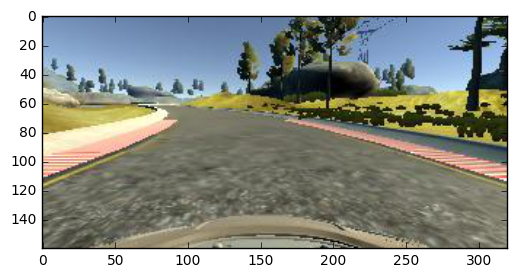

In [110]:
plt.imshow(mpimg.imread(images_path[np.random.randint(0, len(images_path))]))
plt.show()

In [111]:
image_paths, angles = shuffle(image_paths, angles)

In [112]:
def generator(image_paths, angles, batch_size=128):
    
    X,y = ([],[])
    image_paths, angles = shuffle(image_paths, angles)
    while True:       
        for i in range(len(angles)):
            
            image = mpimg.imread(image_paths[i])
            
            X.append(image)
            y.append(angles[i])
            if len(X) == batch_size:
                yield (np.array(X), np.array(y))
                X, y = ([],[])
                image_paths, angles = shuffle(image_paths, angles)
                
            if abs(angles[i]) > 0.3:
                X.append(flipimg(image))
                y.append(-angles[i])
                
            if len(X) == batch_size:   
                yield (np.array(X), np.array(y))
                X, y = ([],[])
                image_paths, angles = shuffle(image_paths, angles)

In [113]:
images_training, images_validation, angles_training, angles_validation = train_test_split(image_paths, angles,
                                                                                  test_size=0.2)

train_generator = generator(images_training, angles_training, batch_size=128)

validation_generator = generator(images_validation, angles_validation, batch_size=128)

In [114]:
from keras.layers.core import K
from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers.core import Reshape
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers import Cropping2D
from keras.layers.core import Dropout
from keras.layers.normalization import BatchNormalization

# Nvidia model

def getNvidiaModel():
    init = 'glorot_normal'
    activation = 'relu'
    keep_prob = 0.5
    keep_prob_dense = 0.7
    
    model = Sequential()

    model.add(Cropping2D(cropping=((60,25), (0,0)), input_shape=(160,320,3)))
    model.add(Lambda(lambda x: K.tf.image.resize_images(x, (66,200)))) # resize image
    model.add(Lambda(lambda x: x/255.0 -0.5)) # normalization

    model.add(Convolution2D(24,5,5, subsample=(2,2), border_mode='valid', init=init))
    model.add(Activation(activation))
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(36,5,5, subsample=(2,2), border_mode='valid', init=init))
    model.add(Activation(activation))
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(48,5,5, subsample=(2,2), border_mode='valid', init=init))
    model.add(Activation(activation))
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(64,3,3, init=init))
    model.add(Activation(activation))
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(64,3,3, init=init))
    model.add(Activation(activation))
    model.add(Dropout(keep_prob))

    model.add(Flatten())
    model.add(Dense(100, init=init))
    model.add(Dropout(keep_prob_dense))
    model.add(Dense(50, init=init))
    model.add(Dropout(keep_prob_dense))
    model.add(Dense(10, init=init))
    model.add(Dropout(keep_prob_dense))
    model.add(Dense(1, init=init))

    return(model)

In [116]:
from keras.layers.core import K
from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers.core import Reshape
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers import Cropping2D
from keras.layers.core import Dropout
from keras.layers.normalization import BatchNormalization

# Nvidia model

def getNvidiaModel():

    keep_prob = 0.5
    keep_prob_dense = 0.7
    
    model = Sequential()

    model.add(Cropping2D(cropping=((60,25), (0,0)), input_shape=(160,320,3)))
    model.add(Lambda(lambda x: K.tf.image.resize_images(x, (66,200)))) # resize image
    model.add(Lambda(lambda x: x/255.0 -0.5)) # normalization

    model.add(Conv2D(24, (5, 5), strides=(2, 2), padding="valid",activation='relu', kernel_initializer="glorot_normal"))
    model.add(Dropout(keep_prob))

    model.add(Conv2D(36,(5, 5), strides=(2, 2), padding="valid", activation='relu', kernel_initializer="glorot_normal"))
    model.add(Dropout(keep_prob))

    model.add(Conv2D(48,(5, 5), strides=(2, 2), padding="valid", activation='relu', kernel_initializer="glorot_normal"))
    model.add(Dropout(keep_prob))

    model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer="glorot_normal"))
    model.add(Dropout(keep_prob))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer="glorot_normal"))
    model.add(Dropout(keep_prob))

    model.add(Flatten())
    model.add(Dense(100, kernel_initializer="glorot_normal"))
    model.add(Dropout(keep_prob_dense))
    model.add(Dense(50, kernel_initializer="glorot_normal"))
    model.add(Dropout(keep_prob_dense))
    model.add(Dense(10, kernel_initializer="glorot_normal"))
    model.add(Dropout(keep_prob_dense))
    model.add(Dense(1, kernel_initializer="glorot_normal"))

    return(model)


In [117]:
model = getNvidiaModel()

model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator=train_generator, steps_per_epoch=len(images_training) // 128,
                    validation_steps=len(images_validation) // 128, epochs=3, verbose=1, 
                    validation_data=validation_generator)

model.save('model1.h5')

Epoch 1/3
85/85 [==============================] - 66s 775ms/step - loss: 0.0737 - val_loss: 0.0686